# Introduction to Recurrent Neural Networks
(c) Deniz Yuret, 2018

* Objectives: learn about RNNs, the RNN layer, compare with MLP on a tagging task.
* Prerequisites: param, train!, Train, Adam, relu

## The Brown Corpus
To introduce recurrent neural networks (RNNs) we will train a part-of-speech tagger using the [Brown Corpus](https://en.wikipedia.org/wiki/Brown_Corpus). We will train three models: a MLP, a unidirectional RNN, a bidirectional RNN and observe significant performance differences.

In [1]:
using Knet: Knet
include(Knet.dir("data/nltk.jl"))
(data,words,tags) = brown()
println("The Brown Corpus has $(length(data)) sentences, $(sum(length(p[1]) for p in data)) tokens, with a word vocabulary of $(length(words)) and a tag vocabulary of $(length(tags)).")

The Brown Corpus has 57340 sentences, 1161192 tokens, with a word vocabulary of 56057 and a tag vocabulary of 472.


`data` is an array of `(w,t)` pairs each representing a sentence, where `w` is a sequence of word ids, and `t` is a sequence of tag ids. `words` and `tags` contain the strings for the ids. 

In [2]:
summary.((data,words,tags))

("57340-element Array{Tuple{Array{UInt16,1},Array{UInt16,1}},1}", "56057-element Array{String,1}", "472-element Array{String,1}")

Here is what the first sentence looks like with ids and with strings:

In [3]:
ENV["COLUMNS"]=120
(w,t) = first(data)
display(permutedims([w t]))
display(permutedims([words[w] tags[t]]))

2×25 Array{UInt16,2}:
 0x000f  0x16e4  0x0510  0x15dd  0x443c  0x003c  0x075e  …  0x000e  0x0009  0x0055  0x2714  0x00dd  0x00bd  0x0003
 0x0003  0x0028  0x0015  0x0027  0x0015  0x000d  0x003a     0x001d  0x000e  0x002e  0x0007  0x000d  0x0001  0x0005

2×25 Array{String,2}:
 "The"  "Fulton"  "County"  "Grand"  "Jury"   "said"  …  "that"  "any"  "irregularities"  "took"  "place"  "."
 "at"   "np-tl"   "nn-tl"   "jj-tl"  "nn-tl"  "vbd"      "cs"    "dti"  "nns"             "vbd"   "nn"     "."

## Word Embeddings
`data` has each sentence tokenized into an array of words and each word mapped to a `UInt16` id. To use these words as inputs to a neural network we further map each word to a Float32 vector. We will keep these vectors in the columns of a size (X,V) matrix where X is the embedding dimension and V is the vocabulary size. The vectors will be initialized randomly, and trained just like any other network parameter. Let's define an embedding layer for this purpose:

In [4]:
using Knet: param
struct Embed; w; end
Embed(vocabsize::Int,embedsize::Int) = Embed(param(embedsize,vocabsize))
(e::Embed)(x) = e.w[:,x]

This is what the words, word ids and embeddings for a sentence looks like: (note the identical id and embedding for the 2nd and 5th words)

In [5]:
embedlayer = Embed(length(words),8)
(w,t) = data[52855]
display(permutedims(words[w]))
display(permutedims(w))
display(embedlayer(w))

1×7 Array{String,2}:
 "Rapping"  "the"  "stick"  "against"  "the"  "desk"  "."

1×7 Array{UInt16,2}:
 0xbb1c  0x0001  0x0bc6  0x00a3  0x0001  0x06b7  0x0003

8×7 Array{Float32,2}:
  0.00449417   0.00490984   0.00462522   -0.0021955     0.00490984   0.00111493    0.00510001
 -0.00301878  -0.00513508   0.00510575   -0.00396186   -0.00513508   0.00187766    0.00400152
 -0.00496544   0.00153929  -0.005417      0.00483976    0.00153929   0.000386565   0.00205652
  0.00307459   0.00590658   0.00278484    0.00171649    0.00590658   0.00556928    0.00333731
 -0.00365931   0.00214283  -0.000839027  -0.00522254    0.00214283  -0.00194581   -0.00428738
 -0.00472921   0.0056069   -0.00395523    0.000618473   0.0056069   -0.00200072   -0.0028218 
 -0.00366795   5.08159e-5   0.00322368    0.00422737    5.08159e-5  -0.00200981   -0.00569366
  0.00189759   0.00565007   0.00143426   -0.00272972    0.00565007  -0.00481315    0.00424067

## Fully connected layers

In [6]:
# Fully connected (Linear) layer with optional activation function at the end
struct FC; w; b; f; end
FC(input::Int,output::Int,f=identity) = FC(param(output,input),param(output),f)
reshape2d(x) = reshape(x,(size(x,1),:))
(fc::FC)(x;o...) = fc.f.(fc.w * reshape2d(x) .+ fc.b)

## RNN layers

In [7]:
# TODO: define these manually, for now just check out @doc RNN
using Knet: RNN

## The three taggers: MLP, RNN, biRNN

In [8]:
# A chain of layers
struct Chain; layers; end
Chain(layer1,layer2,layers...)=Chain((layer1,layer2,layers...))
(c::Chain)(x;o...) = (for l in c.layers; x = l(x;o...); end; x)

In [9]:
Tagger0(vocab,embed,hidden,output)=  # MLP Tagger
    Chain(Embed(vocab,embed),FC(embed,hidden,relu),FC(hidden,output))
Tagger1(vocab,embed,hidden,output)=  # RNN Tagger
    Chain(Embed(vocab,embed),RNN(embed,hidden,rnnType=:relu),FC(hidden,output))
Tagger2(vocab,embed,hidden,output)=  # biRNN Tagger
    Chain(Embed(vocab,embed),RNN(embed,hidden,rnnType=:relu,bidirectional=true),FC(2hidden,output));

In [10]:
# TODO: we need pictures here.

## Sequence Minibatching
Minibatching is a bit more complicated with sequences compared to simple classification problems, this section can be skipped on a first reading. In addition to the input and minibatch sizes, there is also the time dimension to consider. To keep things simple we will concatenate all sentences into one big sequence, then split this sequence into equal sized chunks. The input to the tagger will be size (B,T) where B is the minibatch size, and T is the chunk size. The input to the RNN layer will be size (X,B,T) where X is the embedding size.

In [11]:
BATCHSIZE = 64
SEQLENGTH = 32;

In [12]:
function seqbatch(x,y,B,T)
    N = length(x) ÷ B
    x = permutedims(reshape(x[1:N*B],N,B))
    y = permutedims(reshape(y[1:N*B],N,B))
    d = []; for i in 0:T:N-T
        push!(d, (x[:,i+1:i+T], y[:,i+1:i+T]))
    end
    return d
end
allw = vcat((x->x[1]).(data)...)
allt = vcat((x->x[2]).(data)...)
d = seqbatch(allw, allt, BATCHSIZE, SEQLENGTH);

This may be a bit more clear if we look at an example minibatch:

In [13]:
(x,y) = first(d)
words[x]

64×32 Array{String,2}:
 "The"              "Fulton"    "County"         "Grand"        …  "in"         "term-end"     "presentments" 
 "director"         "of"        "architecture"   "and"             "accepting"  "gifts"        "from"         
 "local"            "club"      "to"             "import"          ","          "who"          "will"         
 "."                "The"       "judge"          "replaced"        "opening"    "of"           "the"          
 "plans"            "titled"    "``"             "Threshold"       "Kong"       "this"         "fall"         
 "admitted"         "for"       "next"           "fall"         …  "interview"  "''"           "."            
 "American"         "system"    "?"              "?"               "the"        "patriotic"    "apprehensions"
 "of"               "the"       "King"           "James"           "``"         "Then"         "cometh"       
 "the"              "misdeeds"  "of"             "his"             "he"         "is"     

Julia indexing allows us to get the embeddings for this minibatch in one go as an (X,B,T) array where X is the embedding size, B is the minibatch size, and T is the subsequence length.

In [14]:
embedlayer = Embed(length(words),128)
summary(embedlayer(x))

"128×64×32 Array{Float32,3}"

## Experiments

In [15]:
VOCABSIZE = length(words)
EMBEDSIZE = 128
HIDDENSIZE = 128
OUTPUTSIZE = length(tags);

In [16]:
# shuffle and split minibatches into train and test portions
using Random; shuffle!(d)
dtst = d[1:10]
dtrn = d[11:end]
length.((dtrn,dtst))

(556, 10)

In [17]:
using Knet: train!, Train, Adam, relu; Knet.gpu()

0

In [18]:
t0 = Tagger0(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
r0 = Train(0:100:2500,dtst)
train!(t0, dtrn; optimizer=Adam(), callback=r0); Knet.gc()
minimum.((r0.losses..., r0.errors...))

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████| Time: 0:00:30


(0.30172020196914673, 0.098876953125)

In [19]:
t1 = Tagger1(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
r1 = Train(0:100:2500,dtst)
train!(t1, dtrn; optimizer=Adam(), callback=r1); Knet.gc()
minimum.((r1.losses..., r1.errors...))

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████| Time: 0:00:29


(0.22708269953727722, 0.06669921874999996)

In [20]:
t2 = Tagger2(VOCABSIZE,EMBEDSIZE,HIDDENSIZE,OUTPUTSIZE)
r2 = Train(0:100:2500,dtst)
train!(t2, dtrn; optimizer=Adam(), callback=r2); Knet.gc()
minimum.((r2.losses..., r2.errors...))

Progress: 100%|█████████████████████████████████████████████████████████████████████████████████| Time: 0:00:30


(0.1702299267053604, 0.04770507812500002)

In [26]:
using Plots; default(fmt=:png,ls=:auto,ymirror=true)

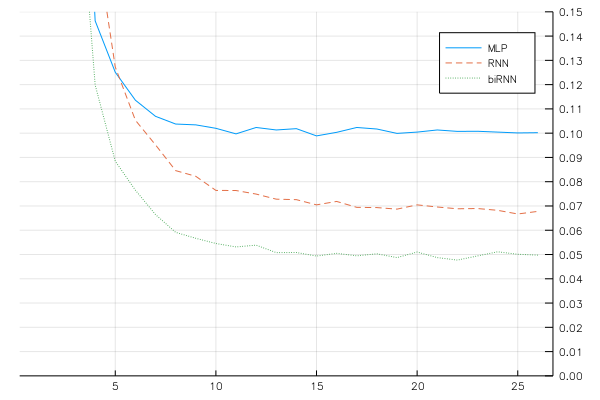

In [22]:
plot([r0.errors, r1.errors, r2.errors]; 
    ylim=(0,0.15), yticks=0:0.01:0.15, labels=["MLP","RNN","biRNN"], ymirror=true)

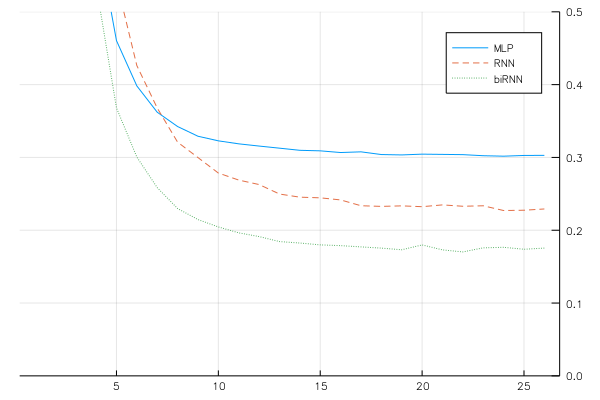

In [23]:
plot([r0.losses, r1.losses, r2.losses]; 
    ylim=(0,.5), yticks=0:0.1:.5, labels=["MLP","RNN","biRNN"])

## Playground
Below, you can type and tag your own sentences:

In [24]:
wdict=Dict{String,UInt16}(); for (i,w) in enumerate(words); wdict[w]=i; end
unk = UInt16(length(words))
wid(w) = get(wdict,w,unk)
function tag(s::String)
    w = permutedims(split(s))
    t = tags[(x->x[1]).(argmax(Array(t2(wid.(w))),dims=1))]
    vcat(w,t)
end

tag (generic function with 1 method)

In [25]:
tag(readline())

stdin> Time flies like an arrow , fruit flies like a banana .


2×12 Array{AbstractString,2}:
 "Time"   "flies"  "like"  "an"  "arrow"  ","  "fruit"  "flies"  "like"  "a"   "banana"  "."
 "nn-tl"  "nns"    "cs"    "at"  "nn"     ","  "nn"     "nns"    "cs"    "at"  "nn"      "."